In [95]:
import os
import pandas as pd
import re
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.interpolate import CubicSpline
from scipy import interpolate

In [96]:
station_all = pd.read_excel("station_with_elevation_heightcanopy.xlsx")

In [99]:
# Set the "station_name" column as the index
station_all = station_all.set_index('station_name')

Naturally, the ICOS stations data gaps are filled from ERA5, so there should not be data gaps. However, the version of ICOS data we have still has data gaps.

In [220]:
selected_station = pd.read_csv("sites_with_noNAs.csv", index_col= 0) # Selecting stations without data gaps.

In [102]:
station = station_all[station_all.index.isin(selected_station.index)] # These are station for which we will drive the model. 

In [103]:
# Initialize an empty dictionary to store station_name, latitude, and longitude and other information..
station_dict = {}

# Iterate over each row in the DataFrame
for index, row in station.iterrows():
    # Extract the station_name and position
    station_name = index
    latitude = row['latitude']
    longitude = row['longitude']
    elevation = row['elevation']
    IGBP_longname = row['IGBP long name']
    IGBP_shortname = row['IGBP short name']
    #start_year = row['Start_Year_Threshold']
    #end_year = row['End_Year_Threshold']
    
    # Extract height_canopy from 'height_canopy_field_information' column or 'height_canopy_ETH' column
    height_canopy = row['height_canopy_field_information']
    if pd.isna(height_canopy):  # Check if height_canopy_field_information is NaN
        height_canopy = row['height_canopy_ETH']

    measurement_height = row['Measurement height']
    
    # Store the station_name, latitude, and longitude in the dictionary
    station_dict[station_name] = {
        'latitude': latitude, 
        'longitude': longitude, 
        'elevation' : elevation,
        'IGBP_longname': IGBP_longname,
        'IGBP_shortname': IGBP_shortname,
        'height_canopy': height_canopy,
        'measurement_height': measurement_height,
        #'start_year': start_year,
        #'end_year': end_year
    }

Since for most stations RH is missing, I want to calculate it and also Qa.

In [104]:
def list_folders_with_prefix(location, prefix):
	"""
    Retrieves a list of folder names within the specified location directory that start with the provided prefix.

    Parameters:
        location (str): The directory path where the function will search for folders.
        prefix (str): The prefix that the desired folders should start with.

    Returns:
        list: A list of folder names starting with the specified prefix within the given location.
    """
    folders_with_prefix = [folder for folder in os.listdir(location) if os.path.isdir(os.path.join(location, folder)) and folder.startswith(prefix)]
    return folders_with_prefix

In [105]:
def list_csv_files_in_folder(folder_path, keyword):
    """
    Retrieves a list of file paths for CSV files within the specified folder_path directory that contain the provided keyword in their filenames.

    Parameters:
        folder_path (str): The directory path where the function will search for CSV files.
        keyword (str): The keyword that the filenames of desired CSV files should contain.

    Returns:
        list: A list of file paths for CSV files containing the specified keyword within the given folder_path.
    """
    csv_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv') and keyword in file]
    return csv_files

In [106]:
location = "/home/khanalp/task1/data/"
prefix = "FLX"
folders = list_folders_with_prefix(location, prefix)

In [107]:
csv_files_with_keyword = []
for folder in folders:
    folder_path = os.path.join(location, folder)
    csv_files_with_keyword.extend(list_csv_files_in_folder(folder_path, "FULLSET_HH"))

In [108]:
#selecting required variables
variables = [
    'TIMESTAMP_START',
    'TA_F',
    'TA_F_QC',
    'SW_IN_F',
    'SW_IN_F_QC',
    'LW_IN_F',
    'LW_IN_F_QC',
    'VPD_F',
    'VPD_F_QC',
    'PA_F',
    'PA_F_QC',
    'P_F',
    'P_F_QC',
    'WS_F',
    'WS_F_QC',
    'RH',
    'CO2_F_MDS',
    'CO2_F_MDS_QC' 
]

In [109]:
#Renaming them
rename = {'TA_F':'Tair',
          'TA_F_QC':'Tair_qc',
          'SW_IN_F':'SWdown',
          'SW_IN_F_QC':'SWdown_qc',
          'LW_IN_F':'LWdown',
          'LW_IN_F_QC':'LWdown_qc',
          'VPD_F':'VPD',
          'VPD_F_QC':'VPD_qc',
          'PA_F':'Psurf',
          'PA_F_QC':'Psurf_qc',
          'P_F' : 'Precip',
          'P_F_QC':'Precip_qc',
          'WS_F':'Wind',
          'WS_F_QC':'Wind_qc',
          'CO2_F_MDS':'CO2air',
          'CO2_F_MDS_QC':'CO2air_qc'
         }

In [111]:
modis_path = "/home/khanalp/task1/data/MODIS_Raw/MODIS_Raw"

In [211]:
def get_spatial_weighted_LAI(lai_pixel,sd_pixel,qc_pixel):
    # Use only good quality data
    qc_flags = [0, 2, 24, 26, 32, 34, 56, 58]
    #Mask the quality flag
    mask = np.isin(qc_pixel, qc_flags)
    lai_pixel[~mask] = np.nan
    sd_pixel[~mask] = np.nan
    # Mask out where sd is really low (likely cloud effects)
    sd_pixel[sd_pixel < 0.1] = np.nan
    lai_pixel[np.isnan(sd_pixel)] = np.nan

    # Set fill values to missing
    lai_pixel[lai_pixel > 10] = np.nan

    # Calculate weights, ignoring NaN values
    weights = (1 / sd_pixel**2) / np.nansum(1 / sd_pixel**2, axis=1, keepdims=True)
    # Element-wise multiplication of lai_pixel and weights
    weighted_lai_values = lai_pixel * weights
    # Calculate the weighted mean for each row, ignoring NaN values
    weighted_lai = np.nanmean(weighted_lai_values, axis=1)

    return weighted_lai

In [212]:
def interpolate_NA_LAI(unfilled_lai):
    filled_lai = unfilled_lai.copy()
    # Create a mask for NaN values
    nan_mask = np.isnan(unfilled_lai)
    # Generate an index array for values
    x = np.arange(len(unfilled_lai))
    # Interpolate only at the positions where NaNs are present
    interp_func = interpolate.interp1d(x[~nan_mask], unfilled_lai[~nan_mask], kind='cubic', fill_value="extrapolate")
    # Extrapolate the NaN values
    filled_lai[nan_mask] = interp_func(x)[nan_mask]
    #Cap negative values to zero
    filled_lai[filled_lai < 0] = 0
    # Also last observation to zero
    filled_lai[-1] = 0

    return filled_lai 

In [213]:
def check_data_availability(filled_lai,lai_time):
    """
    Checks the availability of MODIS LAI data and fills missing values if necessary. It ensures that the provided time range matches the expected range for MODIS observations.

    Parameters:
        filled_lai (numpy.ndarray): Array containing MODIS LAI data.
        lai_time (pandas.Series): Series containing timestamps corresponding to the MODIS LAI data.

    Returns:
        tuple: A tuple containing the filled LAI data and the corresponding dates.
    """

# Check if filled_lai has no NAs or not, because sometimes MODIS observations are missing in between.
    all_tsteps = []

    # Loop over each year from start to end of MODIS data 
    for year in range(lai_time.dt.year.min(), lai_time.dt.year.max()+1):
        # Generate the first two dates for the year
        #year_dates = pd.date_range(start=f"{year}-01-01", periods=2, freq='8D')
        
        # Ensure 46 evenly spaced dates for the rest of the year
        year_dates = pd.date_range(start=f"{year}-01-01", end=f"{year}-12-31", freq='8D')
        
        # Append the datetime series for the current year to the list
        all_tsteps.extend(year_dates)

    #Change to pd datetime. 
    all_time = pd.to_datetime(all_tsteps)
    #Check if all date spaced 8 days apart are present in original MODIS lai_time. 
    result = all_time.isin(lai_time)

    temp_array = np.full(result.shape, np.nan)

    # Fill new array based on the condition of result.
    #This basically fills the point after checking date. 
    fill_index = 0
    for i, val in enumerate(result):
        if val:
            temp_array[i] = filled_lai[fill_index]
            fill_index += 1

    selected_lai = temp_array.reshape(-1, 46)[1:-1] #Basically because each year MODIS has 46 observations, if all are available.
    # Select dates from 2003 to 2022
    selected_dates = all_time[(all_time.year >= 2003) & (all_time.year <= 2023)]

    if len(np.isnan(selected_lai).flatten()) > 0:
        selected_lai_flatten = selected_lai.reshape(-1)
        positions = np.where(np.isnan(selected_lai_flatten))[0]

        if len(positions) > 0:
            for position in positions:
                selected_lai_flatten[position] = (selected_lai_flatten[position-1]+selected_lai_flatten[position+1])/2 #filling with the average of two nearest value
            gap_free_lai = selected_lai_flatten.reshape(-1, 46)
            return gap_free_lai,selected_dates
    else:
        return selected_lai,selected_dates

In [214]:
# Function to calculate rolling mean along rows
def rolling_mean(array, window):
    """
    Calculates the rolling mean along a 1D numpy array.

    Parameters:
        array (numpy.ndarray): Input 1D array.
        window (int): Size of the rolling window.

    Returns:
        numpy.ndarray: Resultant array after applying the rolling mean.
    """
    result = np.full_like(array, np.nan)
    for i in range(array.shape[0]):
        start_index = max(0, i - window // 2)
        end_index = min(array.shape[0], i + (window + 1) // 2)
        result[i] = np.mean(array[start_index:end_index], axis=0)
    return result

In [215]:
def smoothing_lai(gap_free_lai):
    """
    Smoothes the gap-free LAI data by calculating climatology, removing mean climatology to obtain anomalies,
    and applying a rolling mean to the anomalies with a window of +/- 6 months. Finally, it adds the smoothed anomalies
    back to the climatology to obtain smoothed LAI values.

    Parameters:
        gap_free_lai (numpy.ndarray): Array containing gap-free LAI data.

    Returns:
        numpy.ndarray: Smoothed LAI values.
    """
    # Calculate the mean of each column ignoring NaNs (climatology)
    column_means = np.nanmean(gap_free_lai, axis=0)
    # Calculate the anomaly after removing mean climatology. 
    anomaly = gap_free_lai - column_means
    # Calculate running mean anomaly (+/- 6 months either side of each time step)
    anomaly_rolling = rolling_mean(anomaly.flatten(), 13)
    smoothed_lai = anomaly_rolling + np.tile(column_means,(anomaly.shape[0]))
    return smoothed_lai

In [196]:
modis_path,station_name,start_date,end_date = modis_path,station_name,xds_dimension.time.values.min(),xds_dimension.time.values.max()

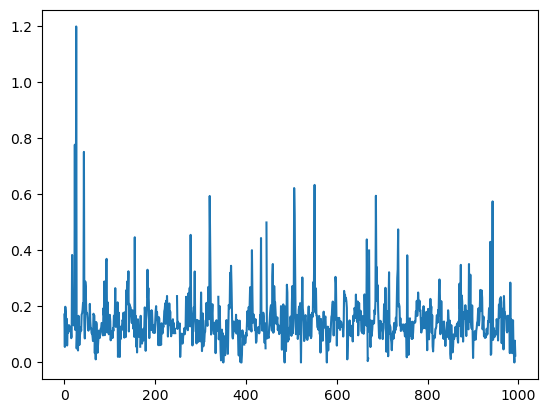

In [201]:
plt.plot(weighted_lai_values)

In [221]:
cams_path

NameError: name 'cams_path' is not defined

In [216]:
def get_LAI(modis_path,station_name,start_date,end_date):
    """
    Retrieves Leaf Area Index (LAI) data from MODIS files for a specific station and time range. 
    The function performs data preprocessing steps including spatial weighting, interpolating missing values, 
    checking data availability, smoothing LAI, and resampling to match the resolution of the flux tower data.

    Parameters:
        modis_path (str): Path to the directory containing MODIS files.
        station_name (str): Name of the station.
        start_date (str): Start date of the desired time range (format: 'YYYY-MM-DD').
        end_date (str): End date of the desired time range (format: 'YYYY-MM-DD').

    Returns:
        numpy.ndarray: Array containing the smoothed LAI values.
    """

    lai_file = glob.glob(f"{modis_path}/{station_name}_MCD15A2H_Lai_500m_*")
    qc_file = glob.glob(f"{modis_path}/{station_name}_MCD15A2H_FparLai_QC*")
    sd_file = glob.glob(f"{modis_path}/{station_name}_MCD15A2H_LaiStdDev_500m_*")
    
    lai = pd.read_csv(lai_file[0])
    qc = pd.read_csv(qc_file[0])
    sd = pd.read_csv(sd_file[0])
    # Get the number of timesteps
    no_tsteps = min(len(lai), len(sd), len(qc)) // max(lai['pixel'])
    
    # Extracting pixels in the centre and immediately around it
    pixel_no = [7, 8, 9, 12, 13, 14, 17, 18, 19]

    # Extract 3x3 pixels
    lai_pixel = np.full((no_tsteps, len(pixel_no)), np.nan)
    sd_pixel = np.full((no_tsteps, len(pixel_no)), np.nan)
    qc_pixel = np.full((no_tsteps, len(pixel_no)), np.nan)
    # Save time stamps
    lai_time = pd.to_datetime(lai.loc[lai['pixel'] == pixel_no[0], 'calendar_date'])

    # Loop through pixels
    for idx, p in enumerate(pixel_no):
        #Get time series for pixel and scale using scale factor
        lai_pixel[:, idx] = lai.loc[lai['pixel'] == p, 'value'].values[:no_tsteps] * lai.loc[lai['pixel'] == p, 'scale'].values[0]
        sd_pixel[:, idx] = sd.loc[sd['pixel'] == p, 'value'].values[:no_tsteps] * sd.loc[sd['pixel'] == p, 'scale'].values[0]
        qc_pixel[:, idx] = qc.loc[qc['pixel'] == p, 'value'].values[:no_tsteps]

    print("Spatial Weighing started")
    weighted_lai_values = get_spatial_weighted_LAI(lai_pixel,sd_pixel,qc_pixel)
    print("Interpolating NAs")
    filled_lai = interpolate_NA_LAI(weighted_lai_values)
    print("checking data availability")
    gap_free_lai, selected_dates = check_data_availability(filled_lai,lai_time)
    print("Smoothing LAI")
    smooth_lai = smoothing_lai(gap_free_lai)
    
    df_lai = pd.DataFrame({'Date':selected_dates, 'LAI' :smooth_lai})

    #Setting Date column as index to do resample to 30 mins, which is the resolution of flux tower.
    df_lai.set_index('Date', inplace=True)
    df_filled = df_lai.resample('30min').ffill() #This does not have date beyond 2020-12-26. 

    # Reindex to extend the index until '2020-12-31' and forward fill
    end_date_extend = pd.to_datetime('2023-12-31 23:30:00')
    df_filled = df_filled.reindex(pd.date_range(start=df_filled.index.min(), end=end_date_extend, freq='30min')).ffill()

    filtered_df = df_filled[(df_filled.index >= start_date) & (df_filled.index <= end_date)]
    lai_array = filtered_df['LAI'].values

    return lai_array

In [217]:
for station_name, station_info in station_dict.items():
    
    for item in csv_files_with_keyword:
        if station_name in item:
            selected_item = item
            break
      
    df = pd.read_csv(selected_item)
    xds = xr.Dataset.from_dataframe(df)
    xds_renamed = xds[variables].rename(rename)
    #Making date and time as index; renaming index to time
    xds_indexed = xds_renamed.assign_coords(index=pd.to_datetime(xds_renamed['TIMESTAMP_START'], format='%Y%m%d%H%M')).rename({'index':'time'})
   # Adding x,y to the dimensions; also dropping variable 'TIMESTAMP_START' because its already indexed
    xds_dimension = xds_indexed.expand_dims({'x': [1], 'y': [2]}).drop_vars('TIMESTAMP_START')
    #Converting x,y to float64 
    xds_dimension['x'] = xds_dimension['x'].astype('float64')
    xds_dimension['y'] = xds_dimension['y'].astype('float64')

    # Assign the coordinate arrays to the dataset
    xds_dimension = xds_dimension.assign_coords({'x': [station_info['longitude']]  , 'y': [station_info['latitude']]})
    # Convert the desired date to a pandas Timestamp
    
    # Get the minimum time value in the dataset
    min_time = pd.Timestamp(xds_dimension.time.min().values)

    # Set the start_date to 2012-01-01 if the minimum time is before 2012, otherwise keep it the same
    start_date = pd.Timestamp('2012-01-01 00:00:00') if min_time < pd.Timestamp('2012-01-01') else min_time
    
    # Select data from 'xds_dimension' after the start_date
    xds_dimension = xds_dimension.sel(time=slice(start_date, None))

    counts = {var: np.count_nonzero(xds_dimension[var].values == -9999) for var in xds_dimension.data_vars}

    if counts['RH'] > 0: 
        # #Grabbing input vpd,Tair, pressure
        vpd = xds_dimension.VPD.values.flatten()
        Tair = xds_dimension.Tair.values.flatten()
        pressure = xds_dimension .Psurf.values.flatten()
        RH, q = calculate_RH_and_q(vpd, Tair, pressure)
        
        xds_dimension['Qair'] = xr.DataArray(q.reshape(1,1,-1), dims=['x','y','time'])
        xds_dimension['RH'] = xr.DataArray(RH.reshape(1,1,-1), dims=['x','y','time'])

    if counts['CO2air'] > 0:
        co2 = get_cams_co2_data(xds_dimension['x'], xds_dimension['y'], xds_dimension.time.min().values, xds_dimension.time.max().values, cams_path)
        xds_dimension['CO2air'] = xr.DataArray(co2.reshape(1,1,-1), dims=['x','y','time'])
    lai = get_LAI(modis_path,station_name,xds_dimension.time.values.min(),xds_dimension.time.values.max())
    xds_dimension['latitude'] = xr.DataArray(np.array(station_info['latitude']).reshape(1,-1), dims=['x','y'])
    xds_dimension['longitude'] = xr.DataArray(np.array(station_info['longitude']).reshape(1,-1), dims=['x','y'])
    xds_dimension['reference_height'] = xr.DataArray(np.array(station_info['measurement_height']).reshape(1,-1), dims=['x','y'])
    xds_dimension['canopy_height'] = xr.DataArray(np.array(station_info['height_canopy']).reshape(1,-1), dims=['x','y'])
    xds_dimension['elevation'] = xr.DataArray(np.array(station_info['elevation']).reshape(1,-1), dims=['x','y'])
    xds_dimension['IGBP_veg_short'] = xr.DataArray(np.array(station_info['IGBP_shortname'], dtype = 'S200'))
    xds_dimension['IGBP_veg_long'] = xr.DataArray(np.array(station_info['IGBP_longname'], dtype = 'S200'))
    
    xds_dimension['LAI'] = xr.DataArray(lai.reshape(1,1,-1), dims=['x','y','time'])
    xds_dimension['LAI_alternative'] = xr.DataArray(lai.reshape(1,1,-1), dims=['x','y','time'])
    
    for var_name in xds_dimension.data_vars:
        if var_name not in ['IGBP_veg_short', 'IGBP_veg_long']:
            xds_dimension[var_name] = xds_dimension[var_name].astype('float32')

    break

Spatial Weighing started
Interpolating NAs
checking data availability
Smoothing LAI


/tmp/ipykernel_965294/3458442836.py:20: RuntimeWarning: Mean of empty slice
  weighted_lai = np.nanmean(weighted_lai_values, axis=1)


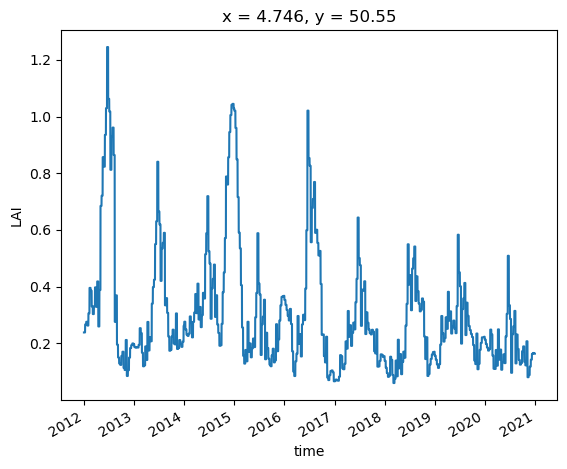

In [218]:
xds_dimension['LAI'].plot()

In [184]:
lai = get_LAI(modis_path,station_name,xds_dimension.time.values.min(),xds_dimension.time.values.max())

Spatial Weighing started
Interpolating NAs
checking data availability
Smoothing LAI


/tmp/ipykernel_965294/352683258.py:18: RuntimeWarning: Mean of empty slice
  weighted_lai = np.nanmean(weighted_lai_values, axis=1)


array([0.16064087, 0.16064087, 0.16064087, ..., 0.07296333, 0.07296333,
       0.07296333])

In [188]:
lai.reshape(1,1,-1).shape

(1, 1, 157824)

In [186]:
xds_dimension

<xarray.Dataset>
Dimensions:           (x: 1, y: 1, time: 157824)
Coordinates:
  * x                 (x) float64 4.746
  * y                 (y) float64 50.55
  * time              (time) datetime64[ns] 2012-01-01 ... 2020-12-31T23:30:00
Data variables: (12/25)
    Tair              (x, y, time) float32 11.35 11.39 11.43 ... 1.738 1.815
    Tair_qc           (x, y, time) float32 2.0 2.0 2.0 2.0 ... 0.0 0.0 0.0 0.0
    SWdown            (x, y, time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SWdown_qc         (x, y, time) float32 2.0 2.0 2.0 2.0 ... 0.0 0.0 0.0 0.0
    LWdown            (x, y, time) float32 361.2 361.2 361.2 ... 312.2 311.5
    LWdown_qc         (x, y, time) float32 2.0 2.0 2.0 2.0 ... 0.0 0.0 0.0 0.0
    ...                ...
    longitude         (x, y) float32 4.746
    reference_height  (x, y) float32 2.7
    canopy_height     (x, y) float32 1.0
    elevation         (x, y) float32 168.6
    IGBP_veg_short    |S200 b'CRO'
    IGBP_veg_long     |S200 b'Croplands'

In [119]:
def get_cams_co2_data(longitude, latitude, start_time, end_time, file_path):
    """
    Retrieve CAMS CO2 data for a specific location and time period.

    Parameters:
    longitude (float): Longitude of the location.
    latitude (float): Latitude of the location.
    start_time (str): Start time in the format 'YYYY-MM-DD'.
    end_time (str): End time in the format 'YYYY-MM-DD'.
    file_path (str): Path to the CAMS netCDF file.

    Returns:
    co2_data (np.ndarray): Array of CO2 data.
    """
    # Open the CAMS dataset
    cams = xr.open_dataset(file_path).sortby('time')

    # Select the nearest location to the provided longitude and latitude
    cams_location_selected = cams.sel(latitude=latitude, longitude=longitude, method='nearest')

    # Select the time range
    cams_date_selected = cams_location_selected.sel(time=slice(start_time, end_time))

    # Extract time and CO2 variables
    time_data = cams_date_selected['time'].values
    co2_data = cams_date_selected['co2'].values.reshape(-1)

    # Create a pandas DataFrame
    df = pd.DataFrame({'time': time_data, 'co2': co2_data})

    # Set 'time' column as index
    df.set_index('time', inplace=True)

    # Resample to 30-minute intervals and forward fill missing values
    df_filled = df.resample('30min').ffill()

    # Extend the index until 'end_time' and forward fill
    end_date_extend = pd.to_datetime(end_time)
    df_filled_new = df_filled.reindex(pd.date_range(start=df_filled.index.min(), end=end_date_extend, freq='30min')).ffill()

    # Extract CO2 data as numpy array
    co2 = np.array(df_filled_new['co2'])

    return co2

In [120]:
def replace_negative_with_mean_of_nearest(arr):
    neg_indices = np.where(arr < 0)[0]  # Get indices where values are less than zero
    for i in neg_indices:
        # Find nearest non-negative values before and after the negative value
        left_index = i - 1
        while left_index in neg_indices:
            left_index -= 1
        right_index = i + 1
        while right_index in neg_indices:
            right_index += 1

        # Replace negative value with the mean of the nearest non-negative values
        arr[i] = np.mean([arr[left_index], arr[right_index]])

    return arr

In [121]:
def calculate_RH_and_q(vpd, Tair, pressure):
    """
    Calculate relative humidity (RH) and specific humidity (q) from input vpd, Tair, and pressure.
    
    Parameters:
    vpd (array-like): Array of vapor pressure deficit values.
    Tair (array-like): Array of air temperature values (in Celsius).
    pressure (array-like): Array of air pressure values (in KPa).
    
    Returns:
    RH (array-like): Array of relative humidity values.
    q (array-like): Array of specific humidity values.
    """
    # Calculating saturation vapor pressure (es) from the Tair.
    es = 0.6108 * np.exp((17.27 * Tair) / (Tair + 237.3)) * 10
    
    # Calculating the actual vapor pressure from es and vpd and then RH.
    ea = es - vpd
    RH = (ea / es) * 100
    RH_modified = replace_negative_with_mean_of_nearest(RH)

    
    # Gas constant of dry air and vapor.
    Rd = 287.058
    Rv = 461.5

    # Calculating the specific humidity (q) from ea.
    w = ea * Rd / (Rv * (pressure * 10 - ea))  # Since pressure in KPa, ea in hPa, same as VPD.
    q = w / (w + 1)
    qair_modified = replace_negative_with_mean_of_nearest(q)
    
    return RH_modified, qair_modified


In [16]:
for station_name, station_info in station_dict.items():
    print(station_name)
    # Find files
    lai_file = glob.glob(f"{modis_path}/{station_name}_MCD15A2H_Lai_500m_*")
    qc_file = glob.glob(f"{modis_path}/{station_name}_MCD15A2H_FparLai_QC*")
    sd_file = glob.glob(f"{modis_path}/{station_name}_MCD15A2H_LaiStdDev_500m_*")
    # Read data
    lai = pd.read_csv(lai_file[0])
    qc = pd.read_csv(qc_file[0])
    sd = pd.read_csv(sd_file[0])
    break

BE-Lon


In [17]:
# Get the number of timesteps
no_tsteps = min(len(lai), len(sd), len(qc)) // max(lai['pixel'])

In [20]:
# Extracting pixels in the centre and immediately around it
pixel_no = [7, 8, 9, 12, 13, 14, 17, 18, 19]

In [21]:
# Extract 3x3 pixels
lai_pixel = np.full((no_tsteps, len(pixel_no)), np.nan)
sd_pixel = np.full((no_tsteps, len(pixel_no)), np.nan)
qc_pixel = np.full((no_tsteps, len(pixel_no)), np.nan)

In [22]:
# Save time stamps
lai_time = pd.to_datetime(lai.loc[lai['pixel'] == pixel_no[0], 'calendar_date'])

In [23]:
# Loop through pixels
for idx, p in enumerate(pixel_no):
    print(idx,p)
    #Get time series for pixel and scale using scale factor
    lai_pixel[:, idx] = lai.loc[lai['pixel'] == p, 'value'].values[:no_tsteps] * lai.loc[lai['pixel'] == p, 'scale'].values[0]
    sd_pixel[:, idx] = sd.loc[sd['pixel'] == p, 'value'].values[:no_tsteps] * sd.loc[sd['pixel'] == p, 'scale'].values[0]
    qc_pixel[:, idx] = qc.loc[qc['pixel'] == p, 'value'].values[:no_tsteps]

0 7
1 8
2 9
3 12
4 13
5 14
6 17
7 18
8 19


## Understanding what is happening in the code
*lai.loc[lai['pixel'] == p, 'value'].values[:no_tsteps] * lai.loc[lai['pixel'] == p, 'scale'].values[0]*
1. This selects the values from the 'value' column of the DataFrame lai where the 'pixel' column is equal to p. It's essentially filtering the 'value' column based on the condition lai['pixel'] == p.

2. .values: This returns the values as a NumPy array.

3. [:no_tsteps]: This slices the array to only include the first no_tsteps elements. It ensures that we only take as many values as there are timesteps.

4. lai.loc[lai['pixel'] == p, 'scale'].values[0]: This selects the scale factor corresponding to the pixel p from the 'scale' column of the DataFrame lai, converts it to a NumPy array, and selects the first value.

5. Multiplication: The values extracted from step 1 are multiplied element-wise with the scale factor obtained from step 4.

6. Assignment: The resulting array is assigned to the corresponding column (idx) in the lai_pixel matrix.

In summary, this line of code populates the lai_pixel matrix with scaled LAI values for a specific pixel p.

In [202]:
qc_flags = [0, 2, 24, 26, 32, 34, 56, 58]

In [203]:
mask = np.isin(qc_pixel, qc_flags)

In [204]:
lai_pixel[~mask] = np.nan
sd_pixel[~mask] = np.nan

In [205]:
# Mask out where QC flag
# Mask out where sd is really low (likely cloud effects)
sd_pixel[sd_pixel < 0.1] = np.nan
lai_pixel[np.isnan(sd_pixel)] = np.nan

# Set fill values to missing
lai_pixel[lai_pixel > 10] = np.nan

In [206]:
# Calculate weights, ignoring NaN values
weights = (1 / sd_pixel**2) / np.nansum(1 / sd_pixel**2, axis=1, keepdims=True)

In [207]:
# Element-wise multiplication of lai_pixel and weights
weighted_lai_values = lai_pixel * weights

In [208]:
weighted_lai_values

array([[0.13457557, 0.03312629, 0.03312629, ...,        nan, 0.99378882,
        0.17598344],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan, 0.17704918, 0.21393443, ...,        nan,        nan,
        0.38360656],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan, 0.5       ,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

In [209]:
# Calculate the weighted mean for each row, ignoring NaN values
weighted_lai = np.nanmean(weighted_lai_values, axis=1)

/tmp/ipykernel_965294/485394860.py:2: RuntimeWarning: Mean of empty slice
  weighted_lai = np.nanmean(weighted_lai_values, axis=1)


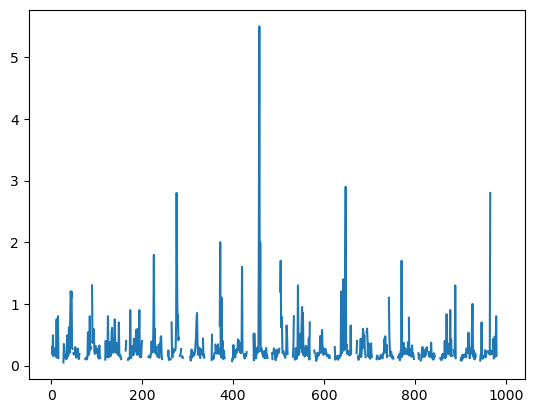

In [210]:
plt.plot(weighted_lai)

**Filling the nan with cubic spline function.**

In [34]:
filled_lai = weighted_lai.copy()

In [35]:
# Create a mask for NaN values
nan_mask = np.isnan(filled_lai)

In [36]:
# Generate an index array for non-NaN values
x = np.arange(len(weighted_lai))

In [37]:
# Interpolate only at the positions where NaNs are present
interp_func = interpolate.interp1d(x[~nan_mask], weighted_lai[~nan_mask], kind='cubic', fill_value="extrapolate")

In [38]:
# Extrapolate the NaN values
filled_lai[nan_mask] = interp_func(x)[nan_mask]

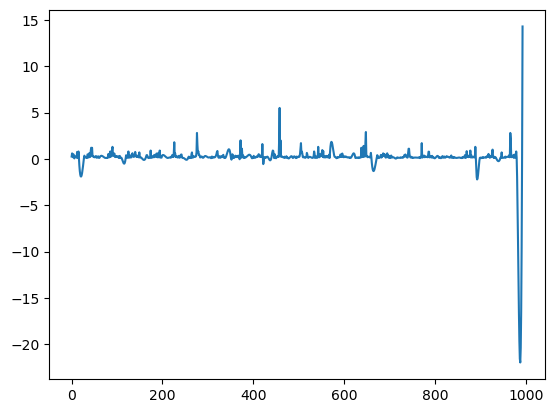

In [39]:
plt.plot(filled_lai)

In [40]:
filled_lai[filled_lai < 0] = 0

In [41]:
filled_lai[-1] = 0

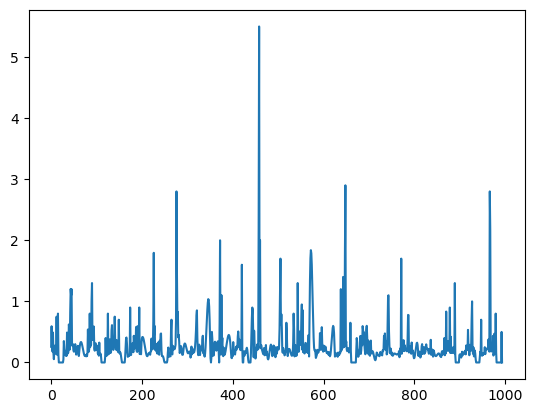

In [42]:
plt.plot(filled_lai)

In [43]:
lai_time.dt.year.max()

2024

In [44]:
all_tsteps = []
# Loop over each year from 2000 to 
for year in range(lai_time.dt.year.min(), lai_time.dt.year.max()+1):
    # Generate the first two dates for the year
    #year_dates = pd.date_range(start=f"{year}-01-01", periods=2, freq='8D')
    
    # Ensure 46 evenly spaced dates for the rest of the year
    year_dates = pd.date_range(start=f"{year}-01-01", end=f"{year}-12-31", freq='8D')
    
    # Append the datetime series for the current year to the list
    all_tsteps.extend(year_dates)


In [45]:
all_time = pd.to_datetime(all_tsteps)

In [46]:
lai_time

5964   2002-07-04
5965   2002-07-12
5966   2002-07-20
5967   2002-07-28
5968   2002-08-05
          ...    
6953   2024-01-17
6954   2024-01-25
6955   2024-02-02
6956   2024-02-10
6957   2024-02-18
Name: calendar_date, Length: 994, dtype: datetime64[ns]

In [47]:
result = all_time.isin(lai_time)

In [48]:
sum(result)

994

In [49]:
# Initialize new array with NaNs
new_array = np.full(result.shape, np.nan)

In [50]:
new_array.shape

(1058,)

In [51]:
# Fill new array based on the condition
fill_index = 0
for i, val in enumerate(result):
    if val:
        new_array[i] = filled_lai[fill_index]
        fill_index += 1

In [52]:
reshaped = new_array.reshape(-1, 46)

In [53]:
reshaped.shape

(23, 46)

In [54]:
only_full = reshaped[1:-1]

In [55]:
lets_reshape = only_full.reshape(-1)

In [56]:
lets_reshape.shape

(966,)

In [57]:
positions = np.where(np.isnan(lets_reshape))[0]
positions

array([886, 910])

In [58]:
selected_lai = new_array.reshape(-1, 46)[1:-1]
selected_lai.shape

(21, 46)

In [59]:
selected_lai_flatten = selected_lai.ravel()
selected_lai_flatten.shape

(966,)

In [64]:
positions = np.where(np.isnan(selected_lai_flatten))[0]
len(positions)

2

In [65]:
for position in positions:
    lets_reshape[position] = (lets_reshape[position-1]+lets_reshape[position+1])/2

In [66]:
np.isnan(lets_reshape).sum()

0

In [67]:
reshaped_1 = lets_reshape.reshape(-1, 46)

In [68]:
# Calculate the mean of each column ignoring NaNs
column_means = np.nanmean(reshaped_1, axis=0)

In [69]:
anomaly = reshaped_1 - column_means

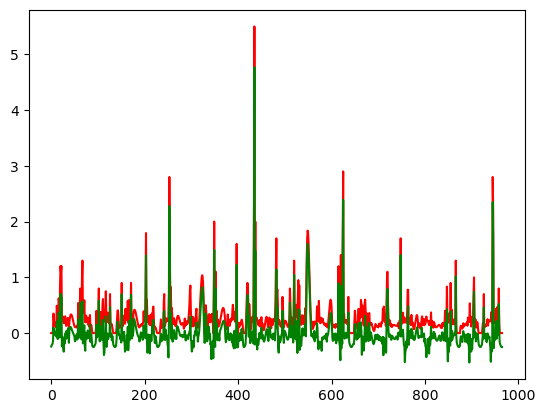

In [70]:
plt.plot(reshaped_1.reshape(-1), color = 'red')
#plt.plot(np.tile(column_means, (23, 1)).reshape(-1), color = 'blue')
plt.plot(anomaly.reshape(-1), color = 'green')

In [71]:
# Function to calculate rolling mean along rows
def rolling_mean(array, window):
    result = np.full_like(array, np.nan)
    for i in range(array.shape[0]):
        start_index = max(0, i - window // 2)
        end_index = min(array.shape[0], i + (window + 1) // 2)
        result[i] = np.mean(array[start_index:end_index], axis=0)
    return result


In [72]:
# Calculate running mean anomaly (+/- 6 months either side of each time step)
window_size = 13  # 6 months on each side plus the current month
anomaly_rolling = rolling_mean(anomaly.flatten(), window_size)

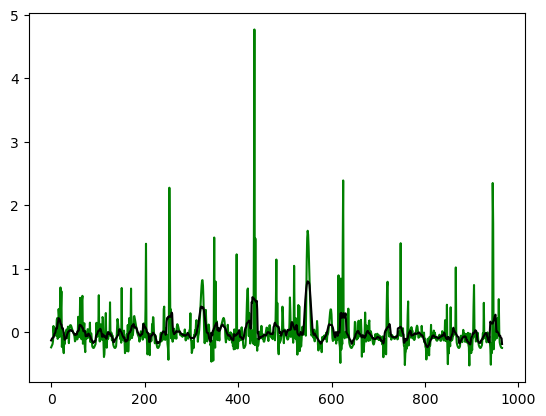

In [73]:
plt.plot(anomaly.reshape(-1), color = 'green')
plt.plot(anomaly_rolling, color = 'black')

In [74]:
anomaly_rolling.shape

(966,)

In [75]:
anomaly.shape

(21, 46)

In [76]:
lai = anomaly_rolling + np.tile(column_means,(anomaly.shape[0]))

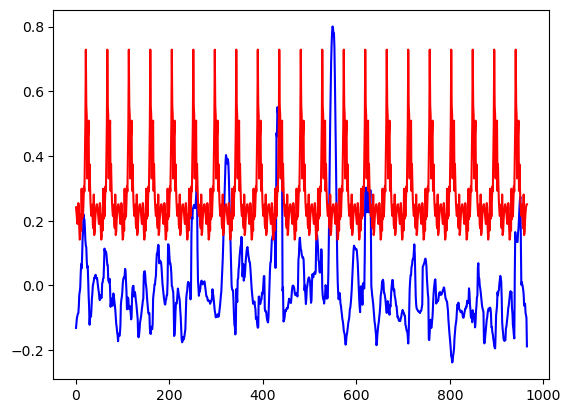

In [77]:
plt.plot(anomaly_rolling, color = 'blue')
plt.plot(np.tile(column_means,(anomaly_rolling.shape[0]//column_means.shape[0])), color = 'red')

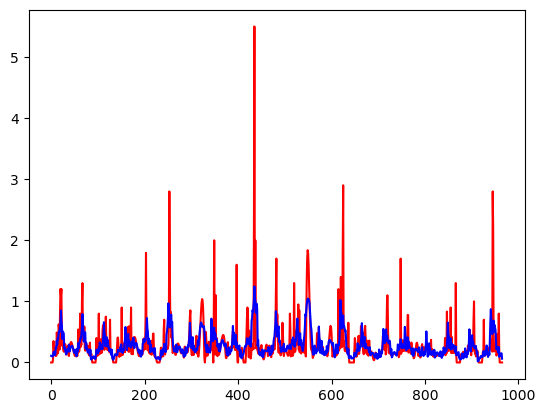

In [78]:
plt.plot(reshaped_1.reshape(-1), color = 'red')
plt.plot(lai, color = 'blue')

In [83]:
# Put in the dataframe with date and fill it to the tsteps of the flux data
lai.shape

(966,)

In [84]:
# Select dates from 2003 to 2022
selected_dates = all_time[(all_time.year >= 2003) & (all_time.year <= 2023)]

In [85]:
selected_dates

DatetimeIndex(['2003-01-01', '2003-01-09', '2003-01-17', '2003-01-25',
               '2003-02-02', '2003-02-10', '2003-02-18', '2003-02-26',
               '2003-03-06', '2003-03-14',
               ...
               '2023-10-16', '2023-10-24', '2023-11-01', '2023-11-09',
               '2023-11-17', '2023-11-25', '2023-12-03', '2023-12-11',
               '2023-12-19', '2023-12-27'],
              dtype='datetime64[ns]', length=966, freq=None)

In [86]:
df_lai = pd.DataFrame({'Date':selected_dates, 'LAI' :lai})

In [87]:
df_lai

,Date,LAI
0,2003-01-01,0.109700
1,2003-01-09,0.107146
2,2003-01-17,0.105006
3,2003-01-25,0.096042
4,2003-02-02,0.106742
...,...,...
961,2023-11-25,0.143683
962,2023-12-03,0.139773
963,2023-12-11,0.148573
964,2023-12-19,0.149771


In [88]:
#Setting Date column as index to do resample to 30 mins, which is the resolution of flux tower.
df_lai.set_index('Date', inplace=True)
df_filled = df_lai.resample('30min').ffill()
#This does not have date beyond 2020-12-26. 

In [89]:
# Reindex to extend the index until '2020-12-31' and forward fill
end_date_extend = pd.to_datetime('2023-12-31 23:30:00')
df_filled = df_filled.reindex(pd.date_range(start=df_filled.index.min(), end=end_date_extend, freq='30min')).ffill()

In [90]:
df_filled

,LAI
2003-01-01 00:00:00,0.109700
2003-01-01 00:30:00,0.109700
2003-01-01 01:00:00,0.109700
2003-01-01 01:30:00,0.109700
2003-01-01 02:00:00,0.109700
...,...
2023-12-31 21:30:00,0.061989
2023-12-31 22:00:00,0.061989
2023-12-31 22:30:00,0.061989
2023-12-31 23:00:00,0.061989


In [91]:
 # Refactor code
# get the LAI within the dates of the xarray
# Batch processing ; write messages within to track where the errors are.

In [92]:
start_date = "2012-01-01 00:00:00"
end_date = "2020-12-31 23:30:00"

In [93]:
filtered_df = df_filled[(df_filled.index >= start_date) & (df_filled.index <= end_date)]

<Axes: >

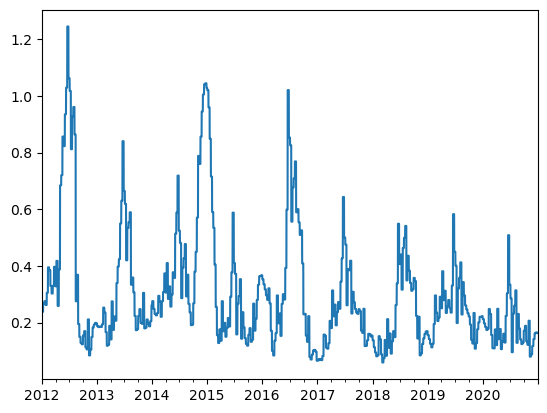

In [193]:
filtered_df['LAI'].plot()

<Axes: >

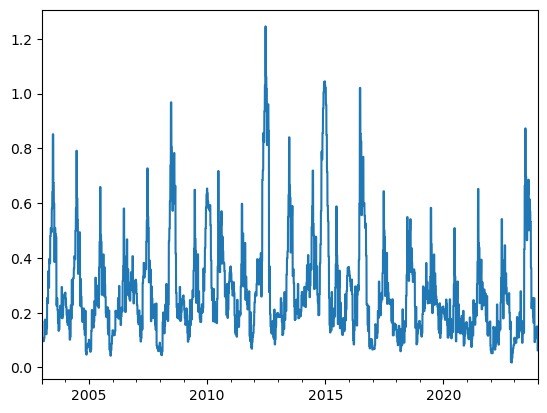

In [88]:
df_filled['LAI'].plot()